# Receipt Matching Data Science Challenge
**Ashok Rayal**

* [**Introduction**](#introduction)
* [**Importing libraries and data**](#import)
* [**Data Preprocessing and Feature Engineering**](#preprocessing)
* [**Visualization using Dimensionality Reduction**](#dimensionalityreduction)
* [**Building model**](#model)
* [**Feature Importance**](#featureimportance)
* [**Ranked predictions**](#rankedpredictions)
* [**Conclusions**](#conclusions)

<font color='red'>Click above hyperlinks to move to subsections</font>

<a id='introduction'></a>

# Introduction

## The business question
Our customers want the ability to automatically match receipt images to the associated
transaction within the tide app. For this we have used an external supplier to extract data
from the receipt images, (for example, the date of the transaction on the receipt, the name of
the merchant, the transaction amount). Each of the data items returned from the external
supplier was compared against the same data from the tide transaction, and a
‘transaction-receipt’ matching vector was created. The elements of the matching vector will
be produced in different ways depending on the underlying data types being matched (for
example for strings it may be a fuzzy matching score, for transaction amounts it may be an
absolute difference of the amounts on the receipt and the transaction, for dates/times it may
be a time delta, some may be discretized measures of confidence).
Since the data extraction from the receipt image is not always perfect (for example the
incorrect string is extracted for the merchant name) we want to build a model to learn which
matching features are the most successful. The ultimate goal is to match a single receipt to
the correct transaction given a number of possible transactions however, given real world
considerations, we want to sort the possible transactions for a given receipt in order of
likelihood of being the correct transaction. So in the app when the customer takes a picture
of a receipt, the app provides a list of transactions likely to match the receipt, with the one
we think is correct at the top of the list. ‘Success’ in this context means that the correct
transaction for the given receipt is at the top of the list, (note, if the correct matching is not in
the data for a given receipt ‘success’ is not possible)

### Data
The data consists of a csv file where ‘member_id’ is the tide customer identifier, ‘receipt_id’
is the unique identifier for a receipt image, ‘matched_transaction_id’ is a unique identifier for
the transaction that we know is the correct match for the receipt_id, ‘feature_transaction_id’
is the unique_identifier for the transaction which was combined with the receipt_id to
produce the matching vector. The rest of the columns are the elements of the matching
vector for the given receipt_id and matched_transaction_id. Note some filtering was
performed in an attempt to reduce the number of receipt-transaction matching vectors
therefore not every receipt was matched with every transaction for the member.

## Solutions overview

* **Assumptions:** this problem assumes a new-coming hosts, therefore we ignore some historical properties such as host's ratings, previous reviews, properties owned, etc. Properties description and images will not be considered either.
* First we retrieve revenue and booking probability of hosts from the `calendar` file.
* The host properties is categorized into three groups:
    - **House properties**: number of rooms, beds, apartment type, locations, etc.
    - **Host policies**: number of extra guess allowed, cancellation policy, verification from rental, etc, as well as host self-verification
    - **Pricing strategies**: price per person, cleaning fee, price surging over the year, etc.
* A light gradient boosting machine is used with 5-fold cross-validation for revenue predictions

<ins>**Instructions**:<ins>
* Uncomment and run below command while running for first time

In [1]:
# !pip install -r requirements.txt

<a id='import'></a>

# Importing libraries and data

## Libraries and settings

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from imblearn.over_sampling import SMOTE
import hiplot as hip
from utils import *

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:,.9f}".format

import warnings
warnings.filterwarnings('ignore')

## Importing data and overview

In [4]:
df = pd.read_csv('data/data_interview_test.csv', sep=':')
df.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000
1,"10,000",10000,"10,468","10,001",0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000
2,"10,000",10000,"10,468","10,003",0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000
3,"10,000",10000,"10,468","10,004",0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000
4,"10,000",10000,"10,468","10,005",0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,0.000000000


<AxesSubplot:>

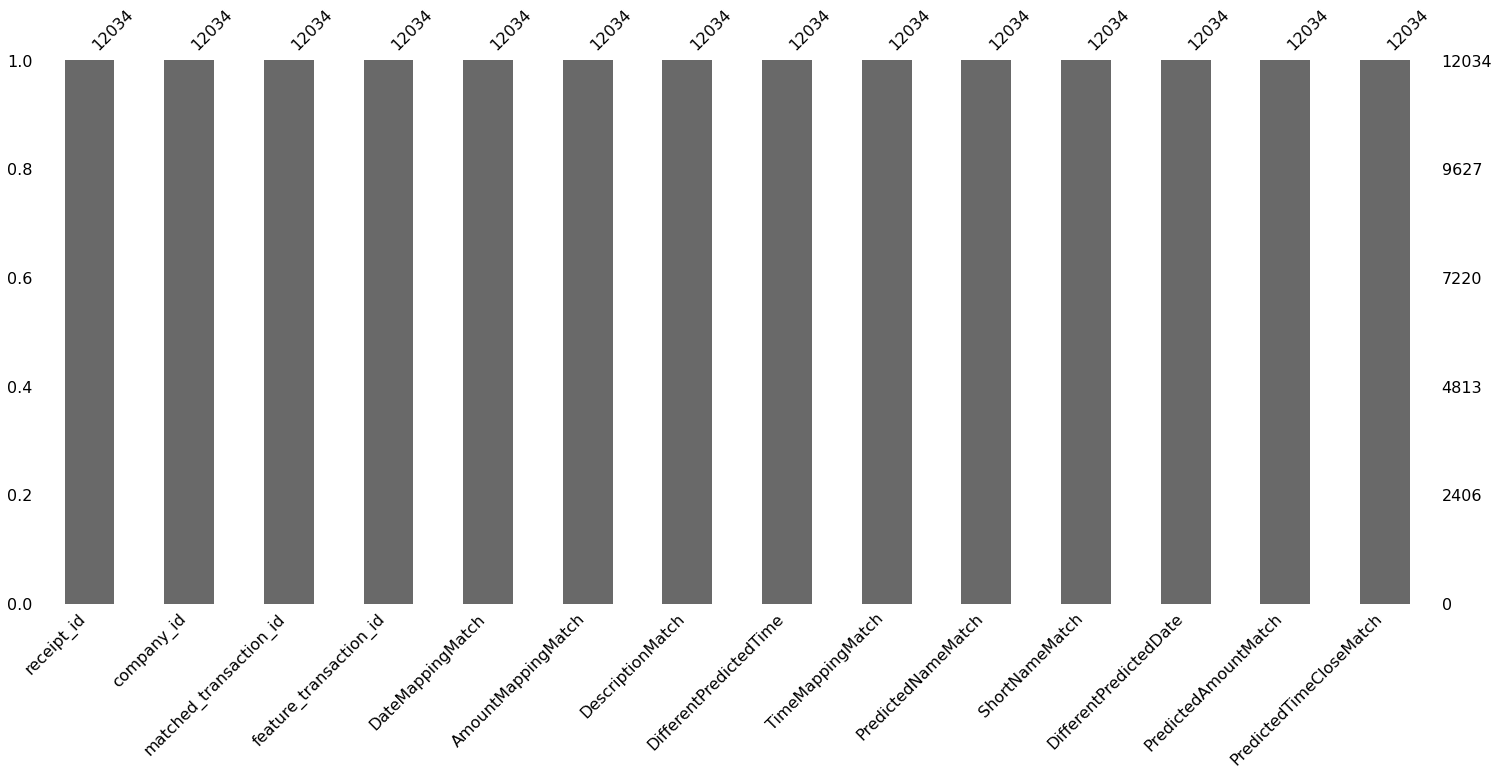

In [5]:
# Checking for missing values
msno.bar(df)

In [6]:
# Check columns data types and do the corrections if required
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  object 
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  object 
 3   feature_transaction_id   12034 non-null  object 
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTime   12034 non-null  float64
 8   TimeMappingMatch         12034 non-null  float64
 9   PredictedNameMatch       12034 non-null  float64
 10  ShortNameMatch           12034 non-null  float64
 11  DifferentPredictedDate   12034 non-null  float64
 12  PredictedAmountMatch     12034 non-null  float64
 13  PredictedTimeCloseMatch  12034 non-null  float64
dtypes: float64(10), int64(

In [7]:
# Remove duplicate records in data
duplicates = df[df.duplicated()].shape[0]!=0 #Duplicates
duplicates

False

<ins>**Observations**:<ins>
* There are no missing values, thats good :) no need to fill missing values.
* All columns are float, int other than id columns so no need to treat categorical features (already in good form)
* There are no duplicate records in data so no need to remove any record

### Target variable analysis

In [8]:
# create target feature receipt match
target_col = 'ReceiptMatch'
df[target_col] = df.apply(lambda x : 1 if x['matched_transaction_id']==x['feature_transaction_id'] else 0, axis=1)

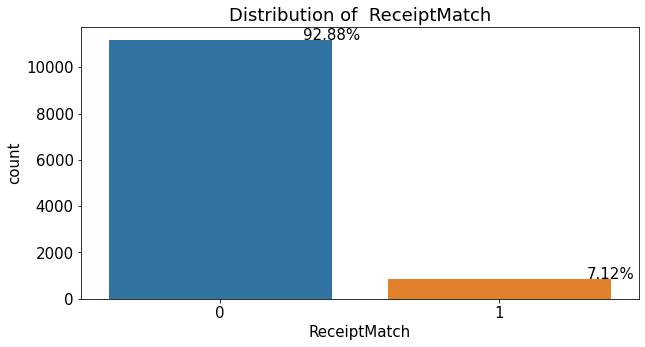

In [9]:
plot_count_plot(df, target_col)

<ins>**Observations**:<ins>
* 7.121% of records have matching as True. That means the data is unbalanced with respect with target variable ReceiptMatch.

### Analysis of ID columns

In [10]:
# check company clients
df['company_id'].value_counts()

30000    4926
20000    2375
10000    2351
50000    1383
40000     999
Name: company_id, dtype: int64

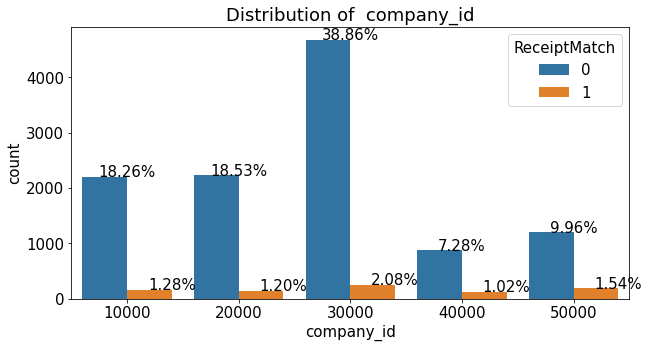

In [11]:
plot_count_plot_with_hue(df, 'company_id', target_col)

In [12]:
df.groupby(['company_id'])['receipt_id'].nunique()

company_id
10000    206
20000    213
30000    370
40000    148
50000    218
Name: receipt_id, dtype: int64

In [13]:
# check total receipts
print(df['receipt_id'].nunique())
df['receipt_id'].value_counts()

1155


30,081    25
30,393    25
30,303    25
30,053    23
30,203    23
          ..
50,085     1
40,130     1
50,096     1
40,118     1
40,007     1
Name: receipt_id, Length: 1155, dtype: int64

In [14]:
print(f"Matched Receipts - {round(100*df[df[target_col]==1].shape[0]/1155,2)} %")

Matched Receipts - 74.2 %


In [15]:
# We have one reciept for one transaction and vice verca
df[df[target_col]==True][['receipt_id', target_col]].groupby('receipt_id').count().max()

ReceiptMatch    1
dtype: int64

In [16]:
# check matched_transaction_id
print(df['matched_transaction_id'].nunique())
df['matched_transaction_id'].value_counts()

1155


31,460    25
31,463    25
31,462    25
30,395    23
30,398    23
          ..
50,306     1
40,264     1
50,028     1
40,327     1
40,027     1
Name: matched_transaction_id, Length: 1155, dtype: int64

In [17]:
# check feature_transaction_id
print(df['feature_transaction_id'].nunique())
df['feature_transaction_id'].value_counts()

2132


30,003    117
30,002    117
30,077    116
30,078    115
30,158    115
         ... 
10,456      1
40,306      1
40,456      1
40,599      1
50,050      1
Name: feature_transaction_id, Length: 2132, dtype: int64

We have 2132 total feature transactions and each has 1 to 117 matching records.

In [18]:
df[['receipt_id', 'matched_transaction_id']].groupby('matched_transaction_id').nunique().max()

receipt_id    1
dtype: int64

<ins>**Observations**:<ins>
* There are total 5 companies. Where records varry from 999 to 4926 and unique receipt varries from 148 to 370.
* Comapnies have similar ratio of matched or not matched. <font color='red'>But we should investigate further companies receipt might play some role in recognition of receipt features </font>
* Total receipts are 1155 in total and one recepit has 1 to 25 matching records. Out of 1155 we have 857 receipts matched (74.2 %)
* Matched transactions are also 1155 in total and 1 to 25 matching records. We have one reciept for one transaction and vice verca.

### Dataframe analysis 

In [19]:
# Lets revert DifferentPredictedTime, DifferentPredictedDate columns for better understanding
df['SamePredictedTime'] = 1 - df['DifferentPredictedTime']
df['SamePredictedDate'] = 1 - df['DifferentPredictedDate']

del df['DifferentPredictedTime']
del df['DifferentPredictedDate']

In [20]:
# lets check if SamePredictedTime and PredictedTimeCloseMatch mean the same thing
df.groupby(['SamePredictedTime', 'PredictedTimeCloseMatch'])['PredictedTimeCloseMatch'].count()

SamePredictedTime  PredictedTimeCloseMatch
0.000000000        0.000000000                11113
                   1.000000000                  758
1.000000000        1.000000000                  163
Name: PredictedTimeCloseMatch, dtype: int64

No they are not the same. There are cases where predicted time is not matched but it is close to the predicted time.
Causes - 1. Time is simple not the same 2. There was some error in recongnizing seconds or mins.

In [21]:
df.groupby(['SamePredictedTime', 'TimeMappingMatch'])['TimeMappingMatch'].count()

SamePredictedTime  TimeMappingMatch
0.000000000        0.000000000         11867
                   1.000000000             4
1.000000000        1.000000000           163
Name: TimeMappingMatch, dtype: int64

In [22]:
# lets check if SamePredictedTime and PredictedTimeCloseMatch mean the same thing
df.groupby(['SamePredictedTime', 'TimeMappingMatch', target_col])['TimeMappingMatch'].count()

SamePredictedTime  TimeMappingMatch  ReceiptMatch
0.000000000        0.000000000       0               11157
                                     1                 710
                   1.000000000       0                   1
                                     1                   3
1.000000000        1.000000000       0                  19
                                     1                 144
Name: TimeMappingMatch, dtype: int64

In [23]:
del df['SamePredictedTime']

<ins>**Observations**:<ins>
* SamePredictedTime and PredictedTimeCloseMatch are not the same thing. There are cases where predicted time is not matched but it is close to the predicted time.
Causes - 1. Time is simple not the same 2. There was some error in recongnizing seconds or mins.
* 'SamePredictedTime', 'TimeMappingMatch' are highly corelated and there are only 4 instances where they differ. We are keeping TimeMappingMatch as its 3 instances are contributing in match.

In [24]:
df.describe()

,company_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,PredictedAmountMatch,PredictedTimeCloseMatch,ReceiptMatch,SamePredictedDate
count,"12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000","12,034.000000000"
mean,"27,247.797905933",0.217901363,0.031660296,0.021522353,0.013877348,0.024214725,0.037892638,0.001005484,0.076533156,0.071214891,0.246468340
std,"12,024.542987575",0.384534850,0.122610944,0.116995018,0.116986769,0.128646054,0.190944535,0.020133836,0.265860312,0.257194143,0.430972310
min,"10,000.000000000",0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
25%,"20,000.000000000",0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
50%,"30,000.000000000",0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
75%,"30,000.000000000",0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
max,"50,000.000000000",1.000000000,0.900000000,0.800000000,1.000000000,0.800000000,1.000000000,0.600000000,1.000000000,1.000000000,1.000000000


In [25]:
# reorder columns to see thing in better way
matching_cols = ['DateMappingMatch', 'SamePredictedDate', 'TimeMappingMatch', 'PredictedTimeCloseMatch',
                 'AmountMappingMatch', 'PredictedAmountMatch', 'DescriptionMatch', 'PredictedNameMatch',  'ShortNameMatch']

matching_cols_with_target = matching_cols.copy()
matching_cols_with_target.append(target_col)

# Check value_counts for all matching columns
for col in matching_cols:
    print(f'{col} value count records')
    print(df[col].value_counts())
    print('-' * 50)

DateMappingMatch value count records
0.000000000    9068
0.950000000    1636
0.850000000     571
0.900000000     217
0.650000000     194
0.825000000     179
0.550000000      98
1.000000000      36
0.750000000      21
0.525000000      11
0.725000000       3
Name: DateMappingMatch, dtype: int64
--------------------------------------------------
SamePredictedDate value count records
0.000000000    9068
1.000000000    2966
Name: SamePredictedDate, dtype: int64
--------------------------------------------------
TimeMappingMatch value count records
0.000000000    11867
1.000000000      167
Name: TimeMappingMatch, dtype: int64
--------------------------------------------------
PredictedTimeCloseMatch value count records
0.000000000    11113
1.000000000      921
Name: PredictedTimeCloseMatch, dtype: int64
--------------------------------------------------
AmountMappingMatch value count records
0.000000000    11225
0.400000000      615
0.700000000      159
0.600000000       26
0.900000000      

<AxesSubplot:>

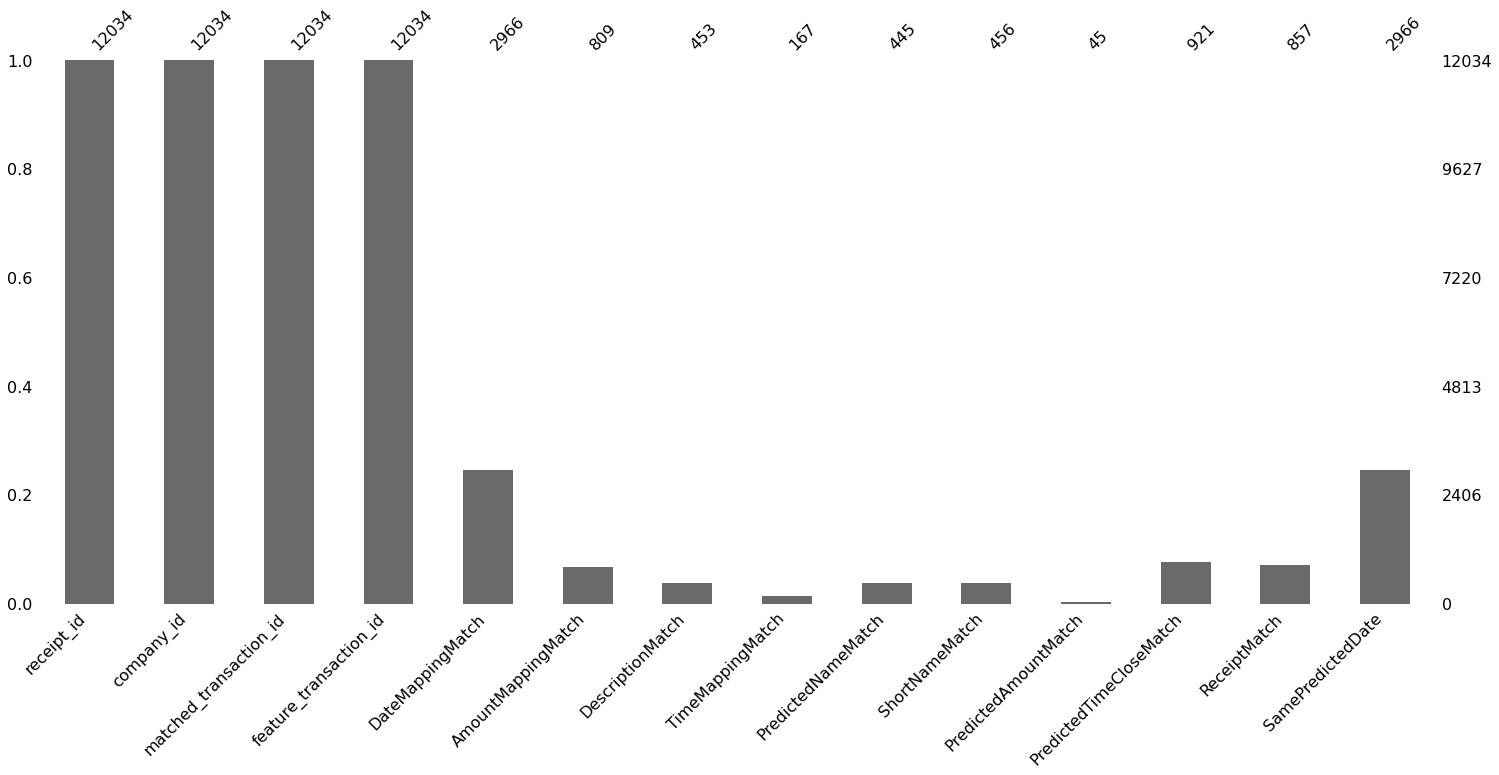

In [26]:
msno.bar(df.replace({0.0:None}))

<AxesSubplot:>

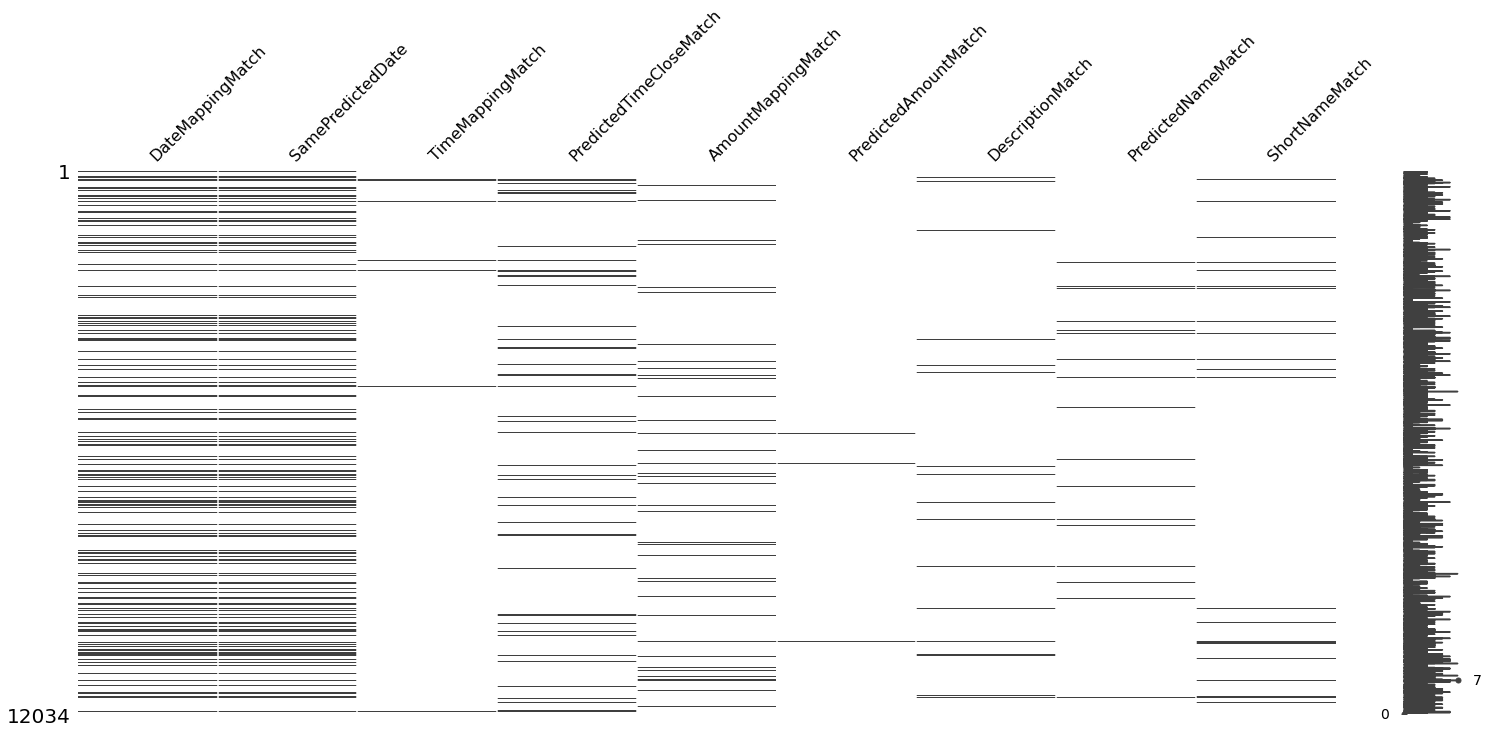

In [27]:
msno.matrix(df[matching_cols].replace({0.0:None}))

In [28]:
# msno.heatmap(df[matching_cols].replace({0.0:None}))
# msno.dendrogram(df[matching_cols].replace({0.0:None}))

<ins>**Observations**:<ins>
* There are lots of zeros in the data. 
* Many obvoius patterns are there like DateMappingMatch and SamePredictedDate are missing together. 

<a id='preprocessing'></a>

# Data Preprocessing and Feature Engineering

### Data to visualize:
* **Date Matching Columns**
* **Time Matching Columns**
* **DescriptionMatch, PredictedNameMatch, ShortNameMatch**

Text(0, 0.5, 'DateMappingMatch')

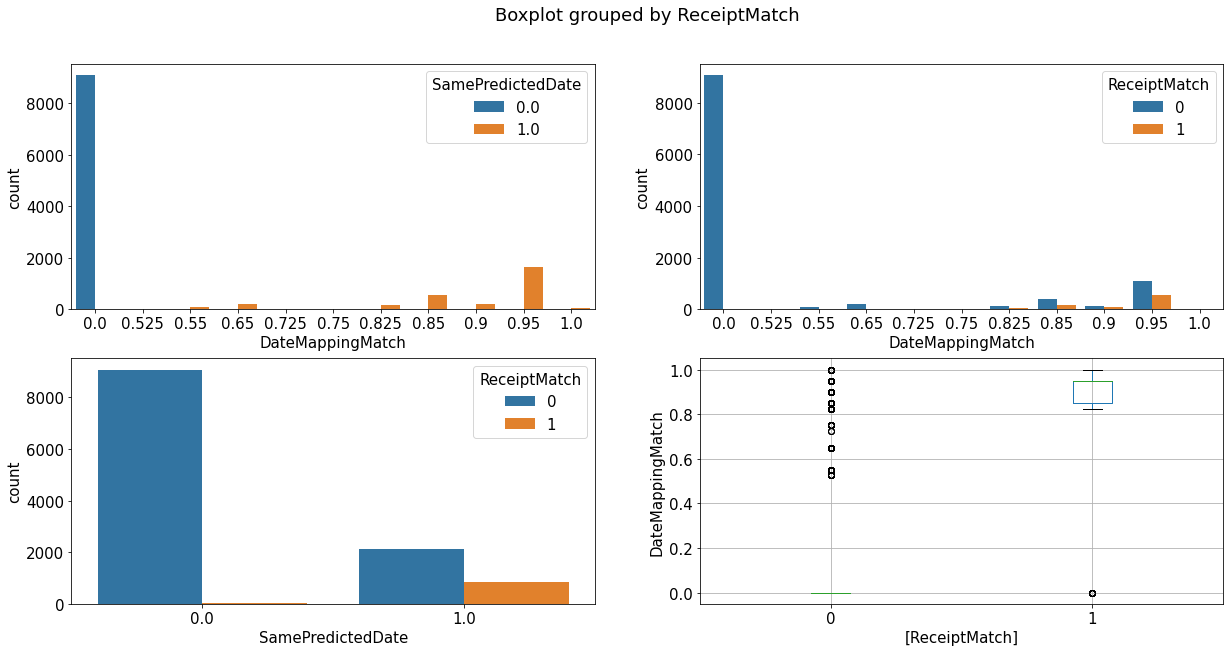

In [29]:
# Date Matching Columns
fig, ax = plt.subplots(2,2, figsize=(20, 10))
sns.countplot(x="DateMappingMatch", hue="SamePredictedDate", data=df[matching_cols_with_target], ax=ax[0][0])
sns.countplot(x="DateMappingMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[0][1])
sns.countplot(x="SamePredictedDate", hue=target_col, data=df[matching_cols_with_target], ax=ax[1][0])
df.boxplot(column=["DateMappingMatch"], by=[target_col], ax=ax[1][1])
ax[1][1].set_title('')
ax[1][1].set_ylabel('DateMappingMatch')

<AxesSubplot:xlabel='PredictedTimeCloseMatch', ylabel='count'>

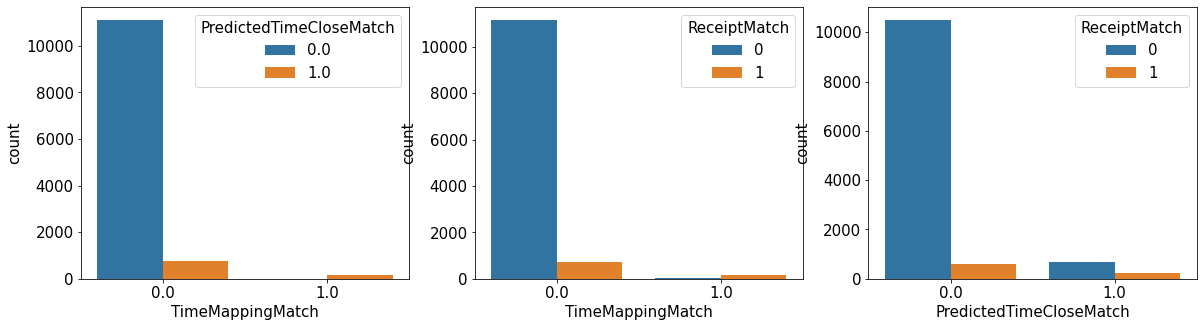

In [30]:
# Time Matching Columns
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.countplot(x="TimeMappingMatch", hue="PredictedTimeCloseMatch", data=df[matching_cols_with_target], ax=ax[0])
sns.countplot(x="TimeMappingMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[1])
sns.countplot(x="PredictedTimeCloseMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[2])

Text(0, 0.5, 'PredictedAmountMatch')

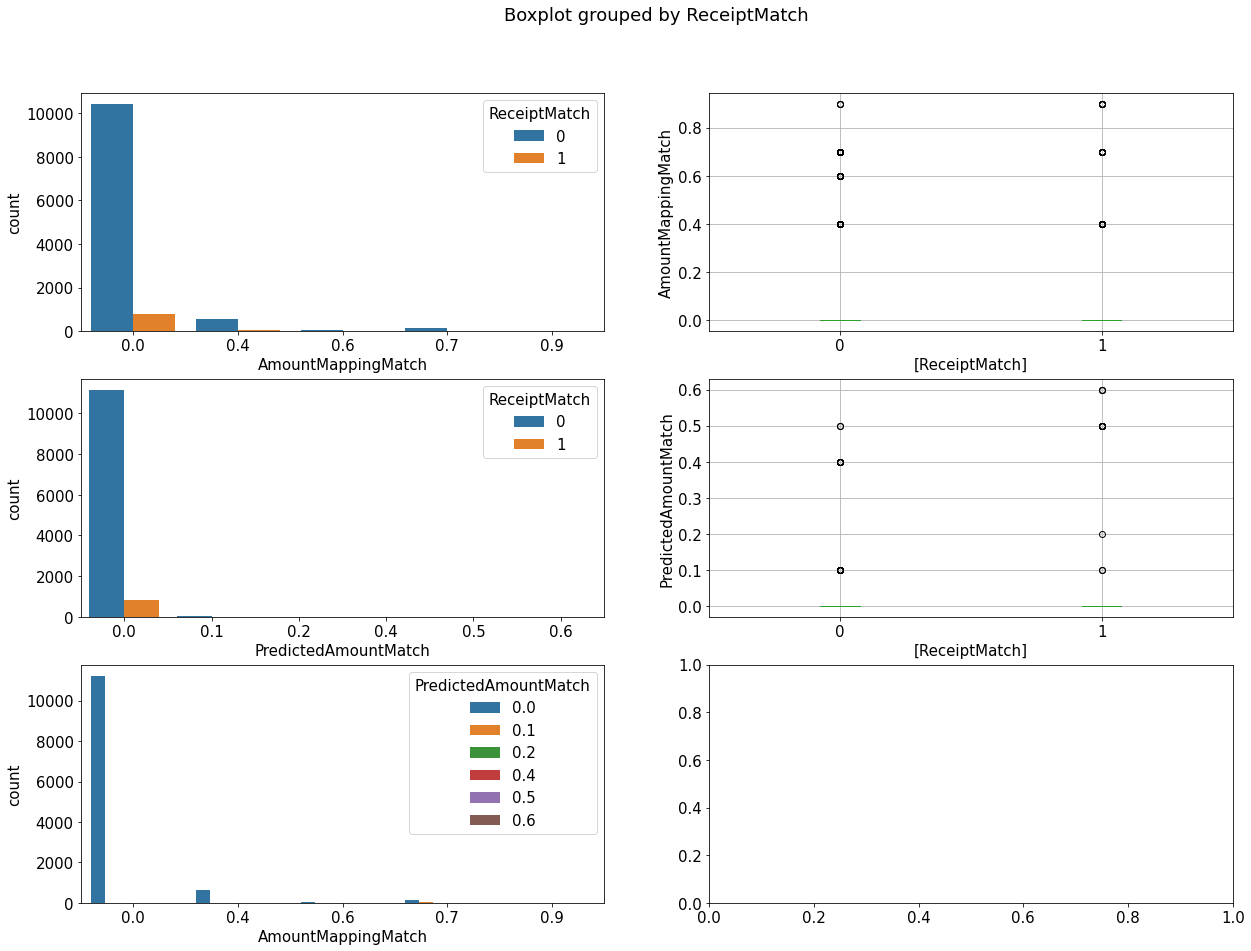

In [31]:
# Amount Matching Columns
fig, ax = plt.subplots(3,2, figsize=(20, 15))
sns.countplot(x="AmountMappingMatch", hue='PredictedAmountMatch', data=df[matching_cols_with_target], ax=ax[2][0])
sns.countplot(x="AmountMappingMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[0][0])
sns.countplot(x="PredictedAmountMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[1][0])

df.boxplot(column=["AmountMappingMatch"], by=[target_col], ax=ax[0][1])
ax[0][1].set_title('')
ax[0][1].set_ylabel('AmountMappingMatch')

df.boxplot(column=["PredictedAmountMatch"], by=[target_col], ax=ax[1][1])
ax[1][1].set_title('')
ax[1][1].set_ylabel('PredictedAmountMatch')

Text(0, 0.5, 'PredictedNameMatch')

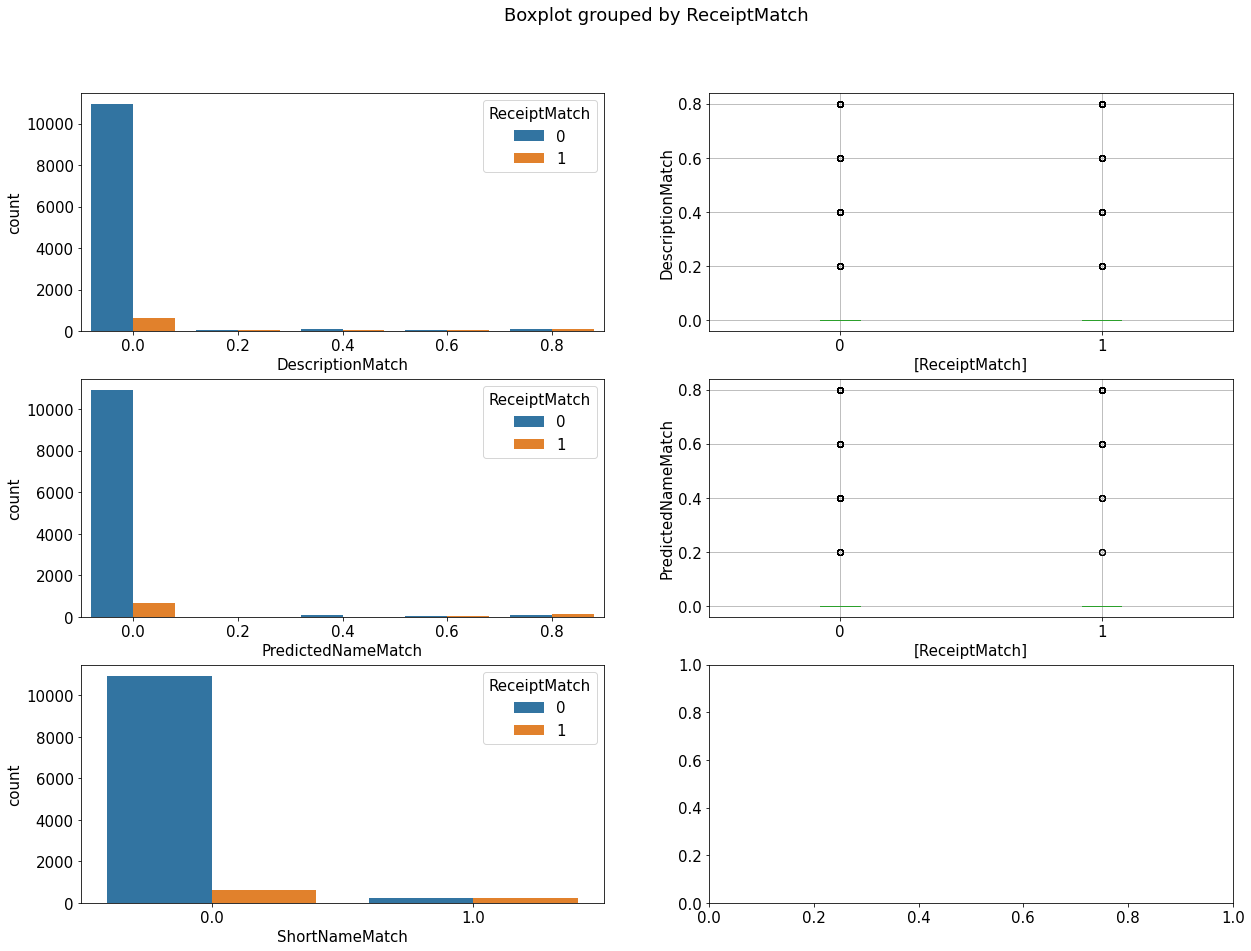

In [32]:
# DescriptionMatch Columns
fig, ax = plt.subplots(3,2, figsize=(20, 15))
sns.countplot(x="DescriptionMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[0][0])
sns.countplot(x="PredictedNameMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[1][0])
sns.countplot(x="ShortNameMatch", hue=target_col, data=df[matching_cols_with_target], ax=ax[2][0])

df.boxplot(column=["DescriptionMatch"], by=[target_col], ax=ax[0][1])
ax[0][1].set_title('')
ax[0][1].set_ylabel('DescriptionMatch')

df.boxplot(column=["PredictedNameMatch"], by=[target_col], ax=ax[1][1])
ax[1][1].set_title('')
ax[1][1].set_ylabel('PredictedNameMatch')

Text(0.5, 1.0, 'Pair-wise correlation')

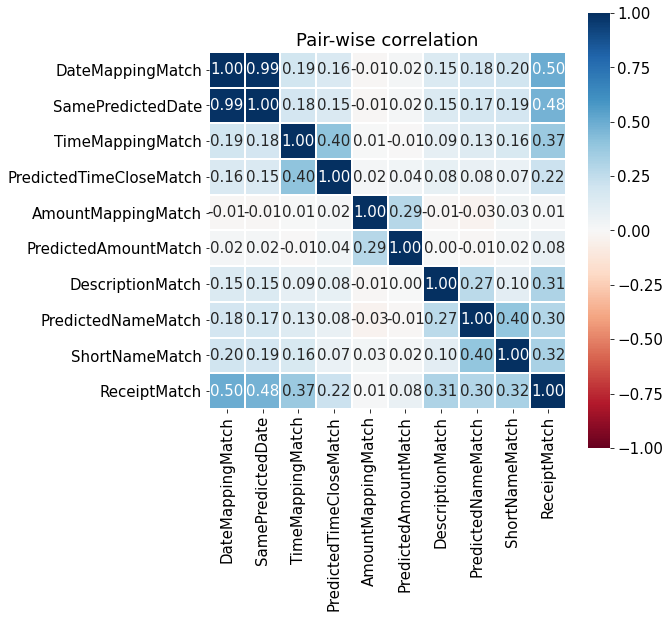

In [33]:
# check corelations between features and target
corr_cols = matching_cols_with_target
colormap = plt.cm.RdBu
plt.figure(figsize=(8,8))
sns.heatmap(df[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

<ins>**Observations**:<ins>
* Almost in columns when match socre increases chance of match also increase (obvious). It is very clearly visible in date matching columns
* Date match columns are highly corelated with each other.
* Date match columns also have a good corelation with target variable as well. 
* DescriptionMatch, PredictedNameMatch, ShortNameMatch and TimeMappingMatch also have good corelation with target
* Many obvoius patterns are there like DateMappingMatch and SamePredictedDate are missing together. 

## Knowledge-based feature

In [34]:
df['PredictedDescriptionMatch'] = df.apply(lambda x : 1.0 if x['DescriptionMatch']>0 else 0.0, axis=1)
df['PredictedPredictedNameMatch'] = df.apply(lambda x : 1.0 if x['PredictedNameMatch']>0 else 0.0, axis=1)
matching_score_cols = ['SamePredictedDate', 'PredictedTimeCloseMatch', 'PredictedAmountMatch', 
                       'PredictedDescriptionMatch', 'PredictedPredictedNameMatch', 'ShortNameMatch']
df['MatchScore'] = df[matching_score_cols].sum(axis=1)/len(matching_score_cols)

Text(0, 0.5, 'MatchScore')

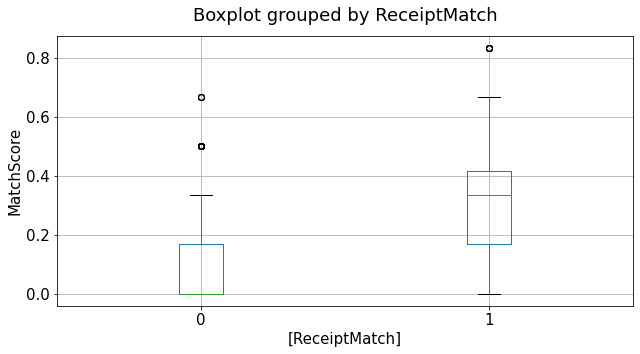

In [35]:
ax = df.boxplot(column=["MatchScore"], by=[target_col] )
ax.set_title('')
ax.set_ylabel('MatchScore')

In [36]:
grouped_multiple = df.groupby(['matched_transaction_id']).agg({'MatchScore': ['count','median', 'max']})
grouped_multiple.columns = ['TotalFilteredTxn', 'MatchScoreMedian', 'MatchScoreMax']
grouped_multiple = grouped_multiple.reset_index()

In [37]:
df = df.merge(grouped_multiple,left_on='matched_transaction_id', right_on='matched_transaction_id', how='left')

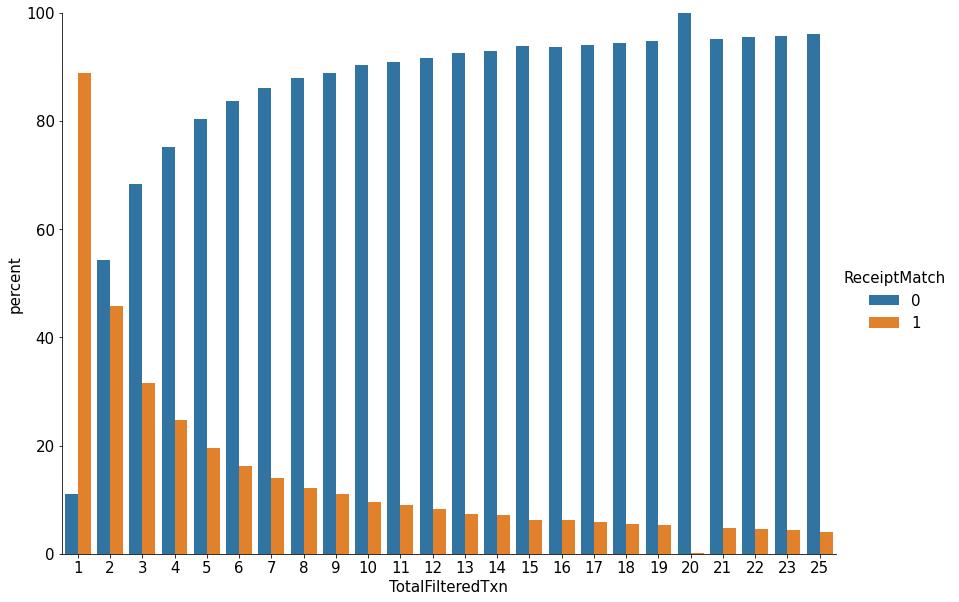

In [38]:
plot_catplot(df, "TotalFilteredTxn", target_col)

In [39]:
# all other features are on 0 to 1 scale. Scale TotalFilteredTxn also to 0 to 1
df['TotalFilteredTxn'] = df['TotalFilteredTxn']/ df['TotalFilteredTxn'].max()

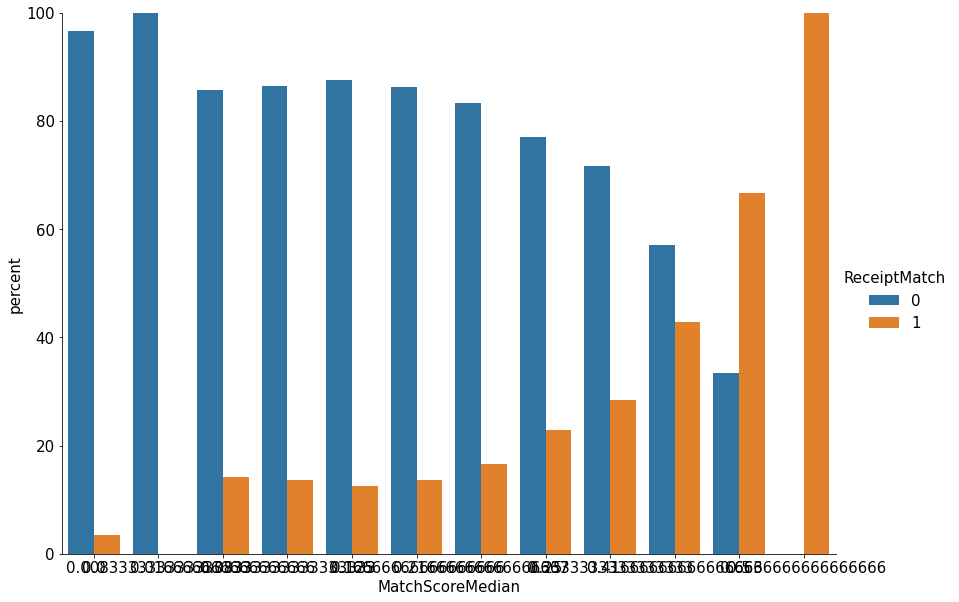

In [40]:
plot_catplot(df, "MatchScoreMedian", target_col)
# sns.histplot(data=df, x="MatchScoreMedian", hue=target_col)

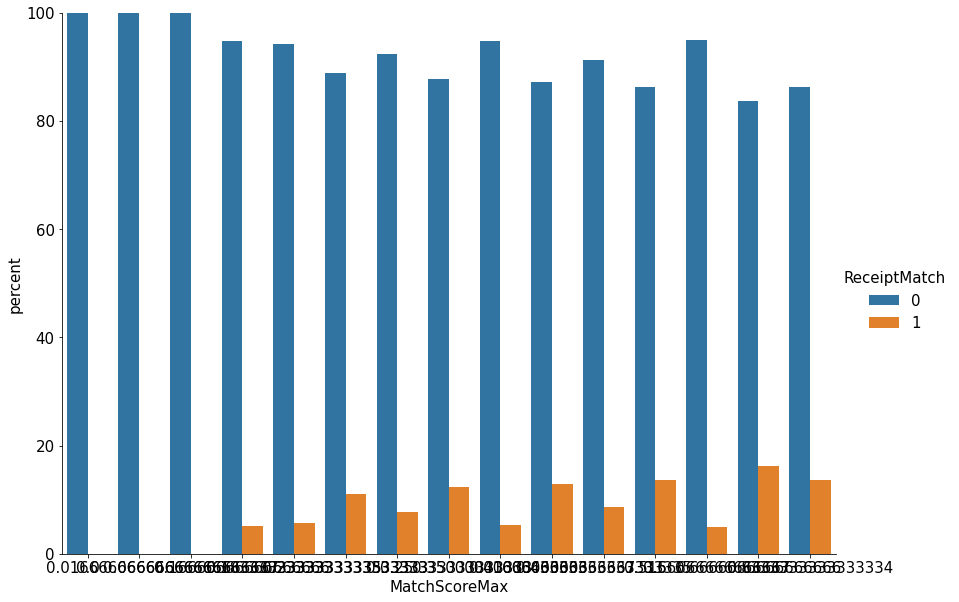

In [41]:
plot_catplot(df, "MatchScoreMax", target_col)
# sns.histplot(data=df, x="MatchScoreMax", hue=target_col)

In [42]:
df['AboveMedian'] = df['MatchScore']>=df['MatchScoreMedian']
df['EqualMax'] = df['MatchScore']>=df['MatchScoreMax']

Text(0, 0.5, 'AboveMedian')

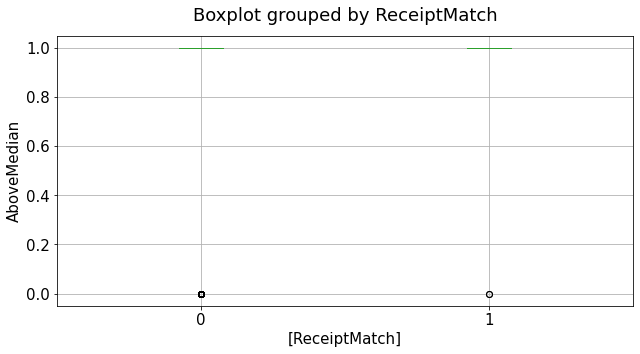

In [43]:
ax = df.boxplot(column=["AboveMedian"], by=[target_col] )
ax.set_title('')
ax.set_ylabel('AboveMedian')

Text(0, 0.5, 'EqualMax')

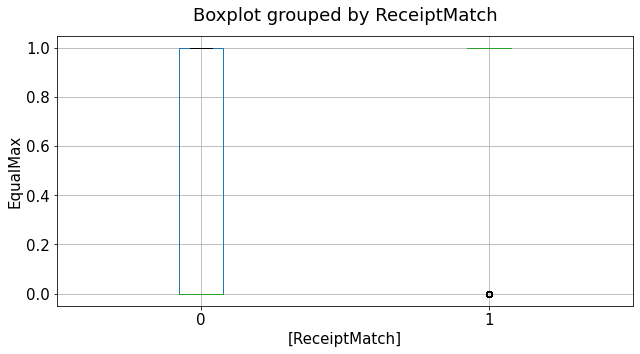

In [44]:
ax = df.boxplot(column=["EqualMax"], by=[target_col] )
ax.set_title('')
ax.set_ylabel('EqualMax')

## Overall view

Text(0.5, 1.0, 'Pair-wise correlation')

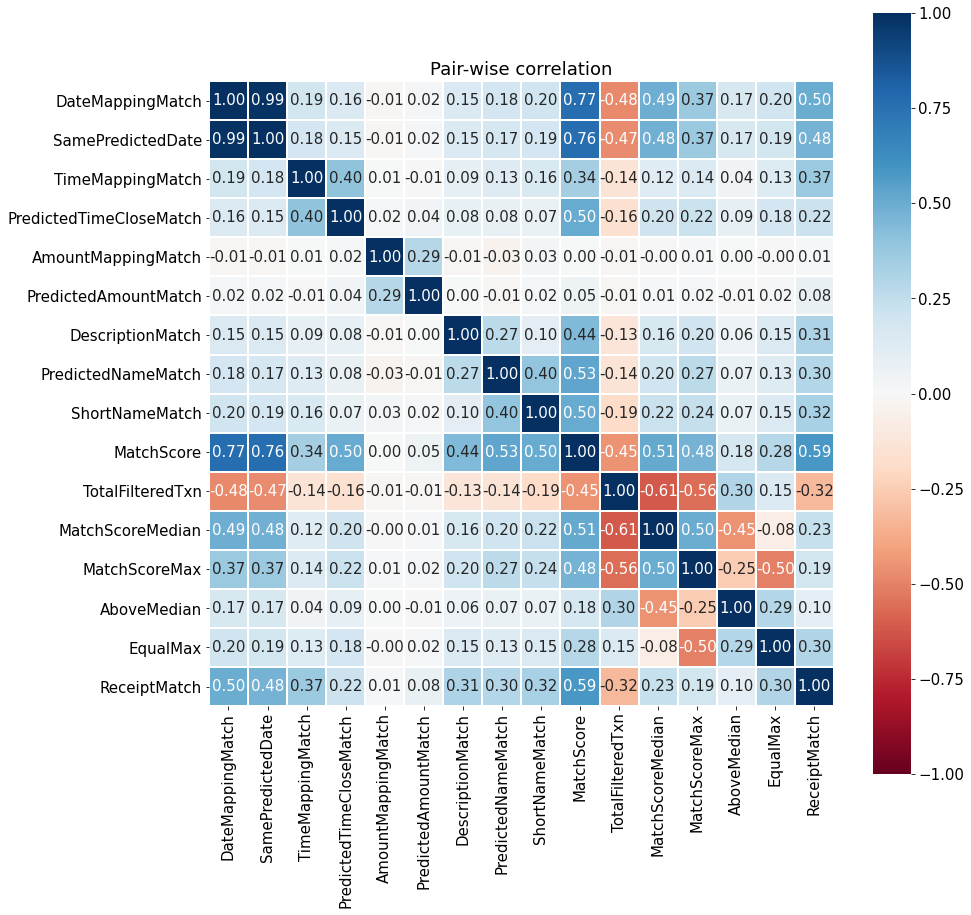

In [45]:
corr_cols = ['DateMappingMatch', 'SamePredictedDate', 'TimeMappingMatch', 'PredictedTimeCloseMatch', 'AmountMappingMatch', 
             'PredictedAmountMatch', 'DescriptionMatch', 'PredictedNameMatch', 'ShortNameMatch', 'MatchScore', 'TotalFilteredTxn',
             'MatchScoreMedian', 'MatchScoreMax', 'AboveMedian', 'EqualMax', target_col]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
sns.heatmap(df[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

<ins>**Observations**:<ins>
* We have multiple rows per receipt so we have created aggregated features to improve perforomance.
* There features are showing interesting patterns which should help in classification. As 
* TotalFilteredTxn(negative), EqualMax(positive) have good corelation with target variable

<a id='dimensionalityreduction'></a>
## Visualization using Dimensionality Reduction

In [46]:
X = df.drop(['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id', target_col], axis=1)
y = df[target_col]

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)

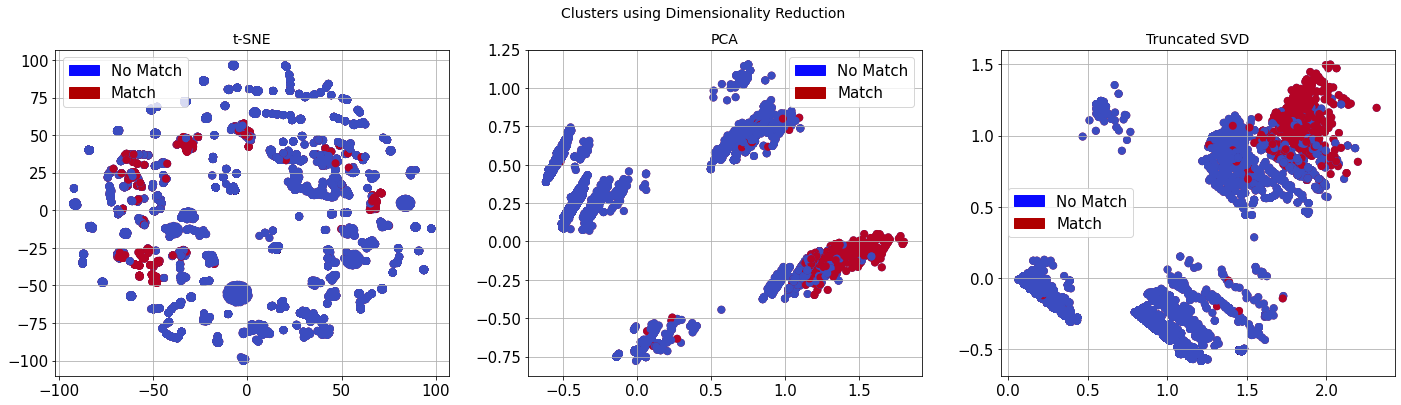

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Match')
red_patch = mpatches.Patch(color='#AF0000', label='Match')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Match', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Match', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Match', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Match', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Match', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Match', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<ins>**Observations**:<ins>
* Although the dataset is pretty small, the PCA and Trucncated SVD algorithms are able to detect clusters to some degree
* This gives us an indication that further predictive models will perform pretty well in separating match from no match cases. 

<a id='model'></a>

# Building simple model using LogisticRegression 

## Preparing data

In [48]:
# Split into predictor and response dataframes.
X_df = df.drop(['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id', target_col], axis=1)
y = df[target_col]

X_df.shape,y.shape

((12034, 17), (12034,))

In [49]:
# Map response variable to integers 0,1.
y.value_counts()

0    11177
1      857
Name: ReceiptMatch, dtype: int64

In [50]:
# Split feature and label sets to train and data sets.

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = 10, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9627, 17), (2407, 17), (9627,), (2407,))

<ins>**Important Points**:<ins>
* Dataset is divied into 80% train and 20% test. Data is stratifyied using target variable. 
* <font color='blue'> We could have also split data across companies. Should try in future</font>
* <font color='blue'> There are many matched and feature combination whrere all matching features are same. These can be handled better like undersampling etc. </font>
* <font color='blue'> Logistic Regression is used here which has good interpretability and class_weight is set to balanced to overcome imblanced dataset problem</font>

## Grid Search with Cross validation

In [51]:
# Use GridSearchCV to find the best parameters.

# params grid
log_reg_params = {"penalty": ['l1', 'l2'],
                  'C': np.logspace(-3,3,7), 
                  'class_weight': ['balanced']}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, return_train_score=True, cv=5)

grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_
print(grid_log_reg.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}


### Cross check overfitting on best results

<ins>**Instructions**:<ins>
* <font color='red'>Select top train and test mean score. Diff between test and train should be minimum. You should see below record highlighted</font>

1. columns - 'param_class_weight', 'param_C', 'param_penalty', 'mean_test_score','mean_train_score'
2. record - balanced	0.1	l2	0.9183543310272283	0.9183287294601452

In [52]:
tdf = pd.DataFrame(grid_log_reg.cv_results_)
grid_cv_results_columns = ['param_class_weight', 'param_C', 'param_penalty', 'mean_test_score','mean_train_score']

exp = hip.Experiment.from_dataframe(tdf[grid_cv_results_columns])
exp.display_data(hip.Displays.PARALLEL_PLOT).update({
        # Hide some columns in the parallel plot
        'hide': ['uid', 'from_uid'],
})
exp.display_data(hip.Displays.TABLE).update({
    # Don't display `uid` and `from_uid` columns to the user
    'hide': ['uid', 'from_uid'],
})
exp.display()

<IPython.core.display.Javascript object>

## Check Learning Curve

<module 'matplotlib.pyplot' from 'C:\\Users\\ashokrayal\\Anaconda3\\envs\\temp\\lib\\site-packages\\matplotlib\\pyplot.py'>

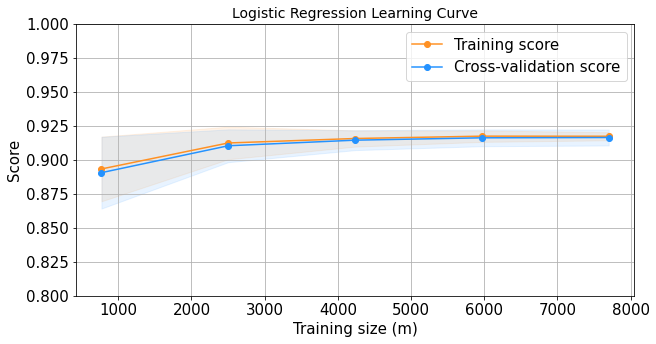

In [53]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, X_train, y_train, (0.80, 1.00), cv=cv, n_jobs=4)

<ins>**Observations**:<ins>
* The wider the gap between the training score and the test score, the more likely your model is overfitting (high variance). 
If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias).
* We have used class_weight = <b>'balanced'</b> as data is imblanced.
* Seleted parameters -  'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'

## Model Performance Metrics

<ins>**Important points**:<ins>
* We are using <b>auc, cohen_kappa_score , confusion matrix </b> here to judge model performance.
* <font color='red'>False negative are less important as we can recommend multiple receipt</font>.
* <font color='red'>False negative occures will also be high as we have many instaces where all features are same but only transcation can be marked as Matched. We will also see in the end where we have multiple transcation predicted match for single receipt with same features and same probability</font>


accuracy_score 0.9187701256881687
auc 0.9782977197781506
balanced_accuracy_score 0.730196420494928
cohen_kappa_score 0.5828160867564484
              precision    recall  f1-score   support

           0       0.92      1.00      0.95      8241
           1       0.94      0.47      0.62      1386

    accuracy                           0.92      9627
   macro avg       0.93      0.73      0.79      9627
weighted avg       0.92      0.92      0.91      9627



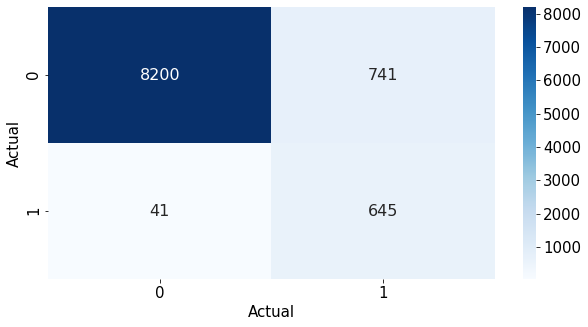

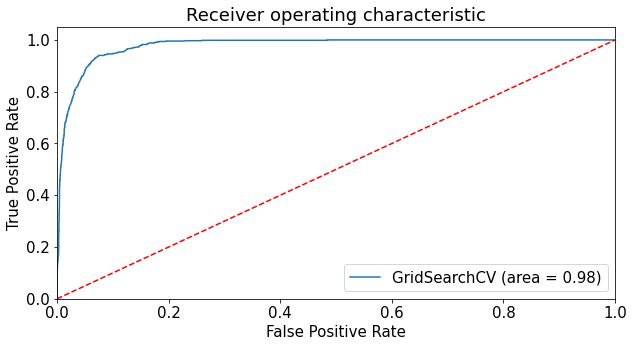

In [54]:
plot_metrics(log_reg, X_train, y_train)

accuracy_score 0.919817199833818
auc 0.9731689838788982
balanced_accuracy_score 0.7285637214293506
cohen_kappa_score 0.5717583267498597
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2081
           1       0.89      0.47      0.61       326

    accuracy                           0.92      2407
   macro avg       0.91      0.73      0.78      2407
weighted avg       0.92      0.92      0.91      2407



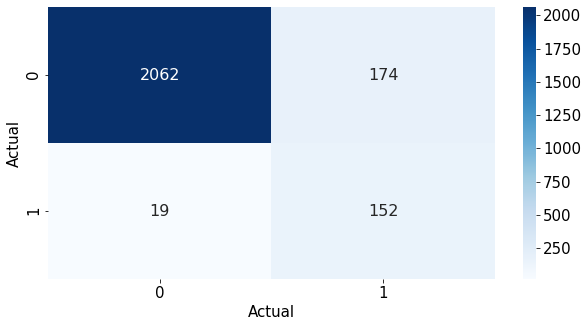

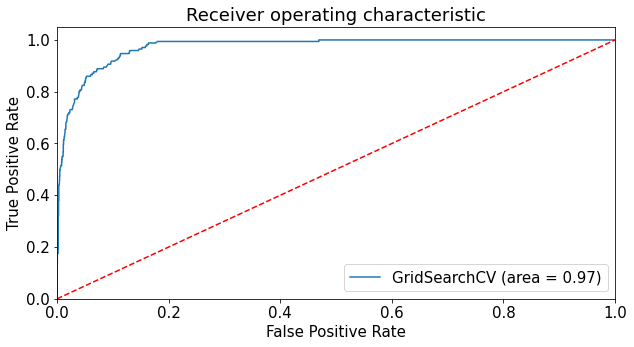

In [55]:
plot_metrics(log_reg, X_test, y_test)

## Logistic regression with SMOTE

In [56]:
# Rerunning above with resampled data
sm_model = LogisticRegression()

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

sm_model.fit(X_train_res, y_train_res)

LogisticRegression()

accuracy_score 0.9151345175028566
auc 0.9811607548415056
balanced_accuracy_score 0.7250101388161917
cohen_kappa_score 0.5733179693077894
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      8194
           1       0.95      0.45      0.61      1433

    accuracy                           0.92      9627
   macro avg       0.93      0.73      0.78      9627
weighted avg       0.92      0.92      0.90      9627



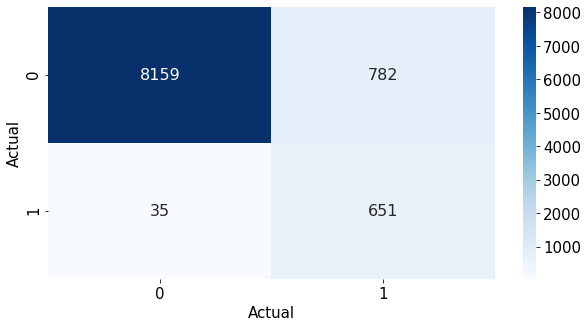

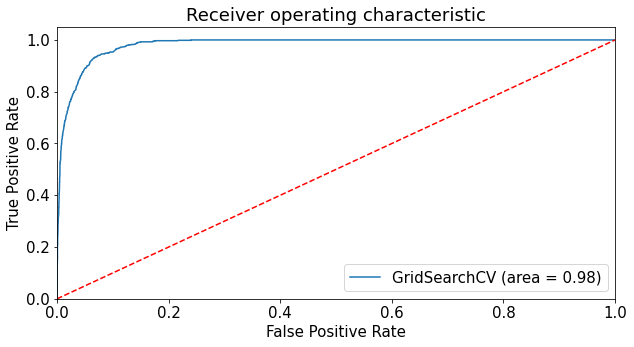

In [57]:
plot_metrics(sm_model, X_train, y_train)

accuracy_score 0.9189862899875364
auc 0.9773064892403938
balanced_accuracy_score 0.7285214182244603
cohen_kappa_score 0.5754032115805785
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2071
           1       0.91      0.46      0.62       336

    accuracy                           0.92      2407
   macro avg       0.92      0.73      0.79      2407
weighted avg       0.92      0.92      0.91      2407



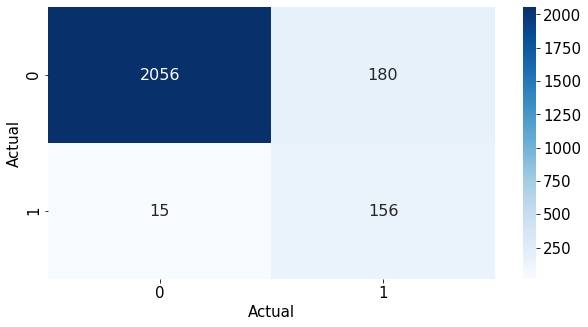

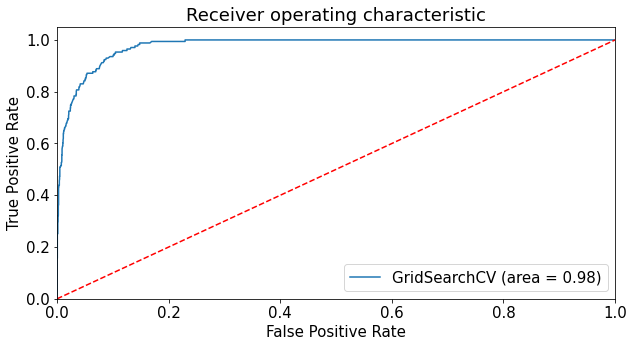

In [58]:
plot_metrics(sm_model, X_test, y_test)

<ins>**Observations**:<ins>
* As expected SMOTE has not improved the model performance much, because data does not have much variation and we have used class_weight='balanced'in first case.

<a id='featureimportance'></a> 

# Feature Importance 

In [59]:
df_importance = pd.DataFrame(X_train.columns, columns=['feature'])
df_importance['importance'] = log_reg.coef_[0]

<AxesSubplot:ylabel='feature'>

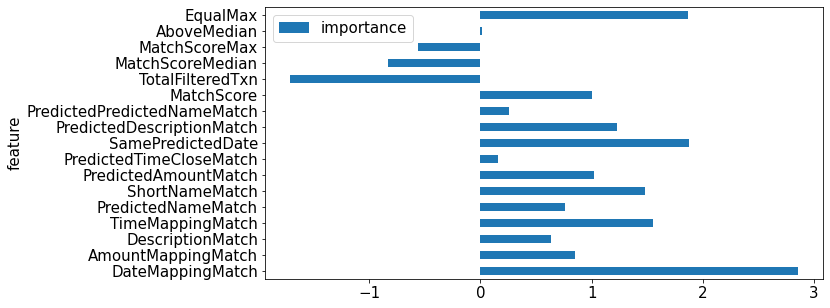

In [60]:
df_importance.plot.barh(x='feature',y='importance')

<ins>**Observations**:<ins>
* This is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0
* DateMappingMatch, EqualMax and PredictedDescriptionMatch are top 3 features for class 1 (Match)
* TotalFilteredTxn, MatchScoreMedian, MatchScoreMax are important for class 0 (No match)
* For more better representation of feature importance we can normalize coefs with std.
* <font color='red'>Feature Importance is relative to Logigistic Regression. For two completely different methods that make use of the features (in conjunction) differently to maximise predictive power, This is why a different set of features offer the most predictive power for each model.</font>

<a id='rankedpredictions'></a>

# Ranked Predictions

In [61]:
X_sample = df[:50]
prediction_columns = X_train.columns
ranked_prediction(log_reg, X_sample, prediction_columns)

,receipt_id,matched_transaction_id,feature_transaction_id,prediction_probs
25,"10,001","10,605","10,605",0.839894166
26,"10,001","10,605","10,606",0.839894166
38,"10,003","10,412","10,412",0.945836315
39,"10,003","10,412","10,413",0.945836315
27,"10,002","10,286","10,286",0.930914740


<ins>**Observations**:<ins>
* ranked_prediction method takes a dataset which has all features already inplace.This should be updated.
* Multiple transactions are predicted with same probability because of same matching vector. One receipt is matched with only one transaction.
* When we predict n matched transcations, and if we treat any match with n is a match. Then false positives goes down and model performance improves fruther.

### Ranked data analysis on complete data

In [62]:
X_sample = df
prediction_columns = X_train.columns
temp_df = ranked_prediction(log_reg, X_sample, prediction_columns, return_complete=True)
df_actual = df[df[target_col]==1][['receipt_id', 'matched_transaction_id']].drop_duplicates()
df_predicted = temp_df[temp_df['prediction']==1].groupby('receipt_id')['feature_transaction_id'].apply(list).reset_index(name='predicted')
ranked_df = df_actual.merge(df_predicted,left_on='receipt_id', right_on='receipt_id', how='outer')

In [63]:
import math
def predict_match(x):
    try:
        if x['matched_transaction_id'] in x['predicted']:
            return True
        else:
            return False
    except:
        return False

In [64]:
ranked_df['ReceiptMatch2'] = ranked_df.apply(predict_match, axis=1)
ranked_df['ReceiptMatch2'].value_counts()

True     797
False     82
Name: ReceiptMatch2, dtype: int64

In [65]:
print(f'{797}({round(100*797/(797+82),2)}) receipts out of {797+82} were sucessfully indentified')

797(90.67) receipts out of 879 were sucessfully indentified


<a id='conclusions'></a>


# Conclusions

## About the data
* Data is highly imbalanced and has low variance. More features and data should be collected.
* Features created based on knowledge have also played a good role in separating two classes.
* In case of less number of records, semi-supervised approach can also be tried to get more labelled data.

## About the code

* The EDA part provide overview about receipts data.
* New features have been created based on the analysis.
* A simple binary logistic regression model is created which is can predict matched transactions with a probability score.
* This probability score can be used to sort matched transactions.
* Important features are also identified with Logistic Regression


## Limitations to be improved

* This notebook has created in hurry and limited time. So there are a lot of things which can be improved. But I have tried to provide a solution that is not the perfect one but simple, easily interpretable and has all the pieces in place. 
* More complex techniques can be used to improve performance. 
* We can also try Ranking, recommendation and matching based techniques.
* Ranking based metrics can be used to better judge model as we also want to give multiple suggestions per receipt.


## Overlooked things due to limited time

* Code comments
* Complex models
* Better plots
* Cross validation results analysis
* Probability distribution of predicted classes
* Shap/LIME feature importances
* Shuffled feature importances (baseline feature importance scores)


**Terms:**

* True Positives: Correctly Classified Match Transactions
* False Positives: Incorrectly Classified Match Transactions
* True Negative: Correctly Classified Non-Match Transactions
* False Negative: Incorrectly Classified Non-Match Transactions
* Precision: True Positives/(True Positives + False Positives)
* Recall: True Positives/(True Positives + False Negatives)
* Precision as the name says, says how precise (how sure) is our model in detecting match transactions while recall is the amount of match cases our model is able to detect.
* Precision/Recall Tradeoff: The more precise (selective) our model is, the less cases it will detect.